In [8]:
import numpy as np
import rasterio, rasterio.mask, fiona
from rasterio.plot import show
import sklearn.cluster
import matplotlib.pyplot as plt

In [2]:
# For K-means applied in CHM database
dataset = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/CHM_Teste_Kmeans.tif')

# Test excluding inf values that actually represent no values

# Read as int numpy array. If CHM, multiply by 100 to avoid losing centimer values
chm = dataset.read(1).astype(int)*100

#chm[chm==np.inf]=np.nan
#chm[chm==dataset.nodata] = np.nan


# Use mask to disconsider nodata or infinity values values
chm_mask = np.ma.masked_array(chm, mask=(chm == chm.min()))#dataset.nodata))# works for tiff statistics, but not for classification algorithms

print('shape: ', chm_mask.shape)
print('mean: ', chm_mask.mean()/100)
print('standard deviation: ', chm_mask.std()/100)
print('minimum: ', chm_mask.min()/100)
print('maximum: ', chm_mask.max()/100)
#print('no data value: ', dataset.nodata)
chm_mask
#plt.imshow(chm)
#plt.show()

# For K-means applied in RGB database
#dataset2 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Mosaic_PtsControle.tif')
# Read as numpy array
#red = dataset2.read(1)
#green = dataset2.read(2)
#blue = dataset2.read(3)

shape:  (499, 736)
mean:  5.313465858231012
standard deviation:  2.425368222155655
minimum:  1.0
maximum:  13.0


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, 900, 900, ..., 400, 400, --],
        [--, 1000, 1000, ..., 400, 400, --],
        [--, --, --, ..., 400, 400, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True, False, False, ..., False, False,  True],
        [ True, False, False, ..., False, False,  True],
        [ True,  True,  True, ..., False, False,  True]],
  fill_value=999999)

shape:  (367264, 1)


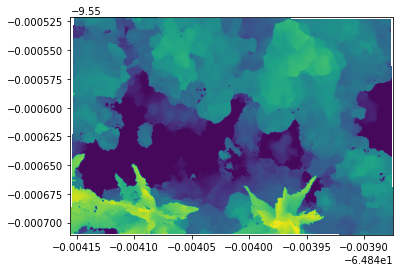

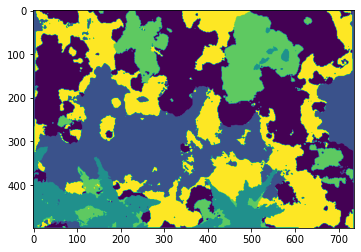

In [10]:
# For CHM data only
original_shape = chm_mask.shape # so we can reshape the labels later
samples = np.column_stack([chm_mask.flatten()])
print('shape: ', samples.shape)

# For RGB data
#original_shape = red.shape # so we can reshape the labels later
#samples = np.column_stack([red.flatten(), green.flatten(), blue.flatten()])

clf = sklearn.cluster.KMeans(n_clusters=5)
labels = clf.fit_predict(samples).reshape(original_shape)

#plt.imshow(labels)
show(dataset)
show(labels)
plt.show()

In [19]:
# Tutorial in https://towardsdatascience.com/sentinel-2-image-clustering-in-python-58f7f2c8a7f6
import rasterio as rio
from rasterio.plot import show
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np

In [12]:
dataset = rio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/RGB_Teste_Kmeans.tif')
print(dataset.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1478, 'height': 995, 'count': 3, 'crs': CRS.from_epsg(32720), 'transform': Affine(0.020840835639180866, 0.0, 297584.1663266284,
       0.0, -0.021063620593932297, 8943742.234605309)}


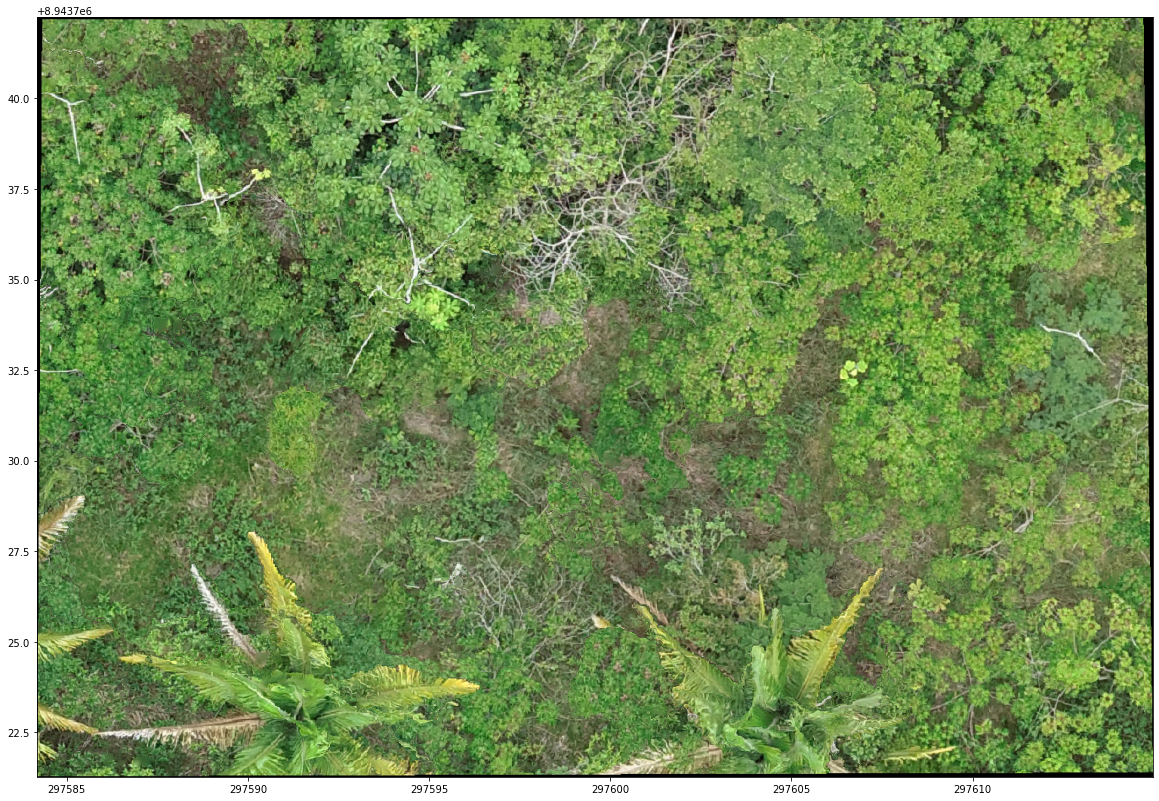

In [13]:
chm = dataset.read()
vmin, vmax = np.nanpercentile(chm, (5,95))  # 5-95% contrast stretch
# show the enhanced image
plt.figure(figsize=[20,20])
show(dataset, cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

In [14]:
# create an empty array with same dimension and data type
imgxyb = np.empty((dataset.height, dataset.width, dataset.count), dataset.meta['dtype'])
# loop through the raster's bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = dataset.read(band+1)
    
print(imgxyb.shape)

(995, 1478, 3)


In [15]:
# convert to 1d array
img1d=imgxyb[:,:,:3].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))
print(img1d.shape)

(1470610, 3)


In [16]:
cl = cluster.KMeans(n_clusters=5) # create an object of the classifier
param = cl.fit(img1d) # train it
img_cl = cl.labels_ # get the labels of the classes
img_cl = img_cl.reshape(imgxyb[:,:,0].shape) # reshape labels to a 3d array (one band only)

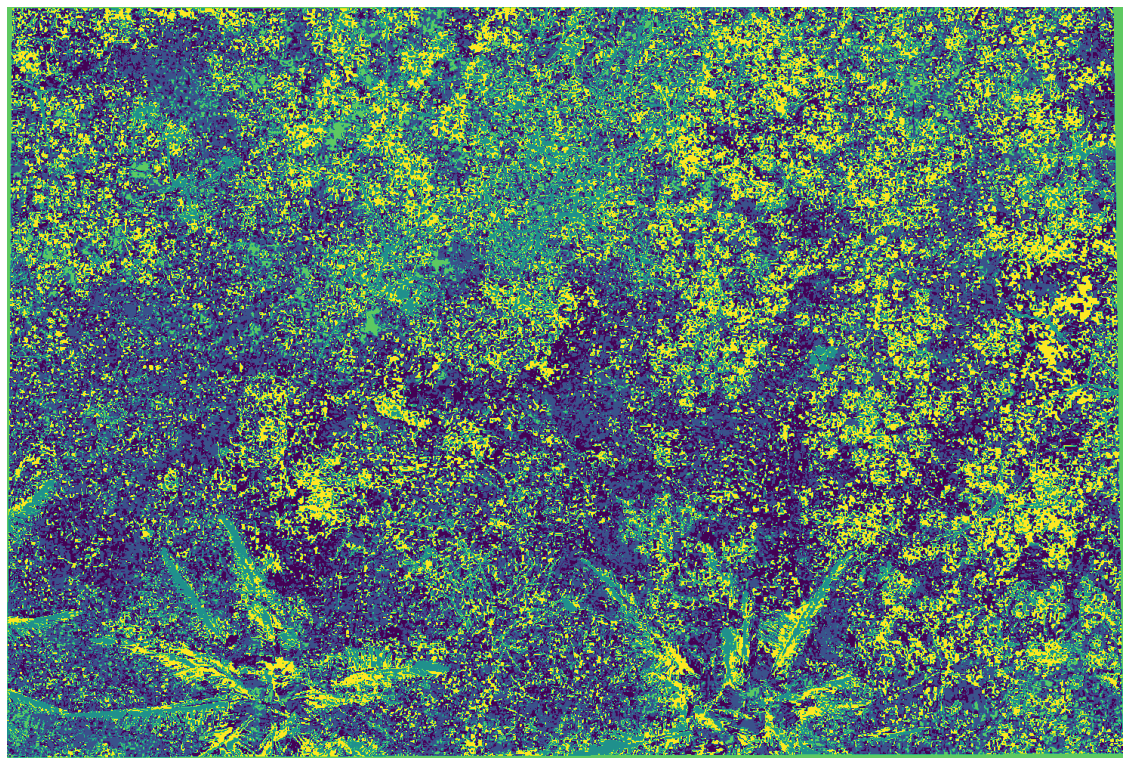

In [17]:
# Create a custom color map to represent our different 4 classes
#cmap = mc.LinearSegmentedColormap.from_list("", ["black","red","green","yellow"])
# Show the resulting array and save it as jpg image
plt.figure(figsize=[20,20])
plt.imshow(img_cl)#, cmap=cmap)
plt.axis('off')
#plt.savefig("/path_to/name_image.jpg", bbox_inches='tight')
plt.show()

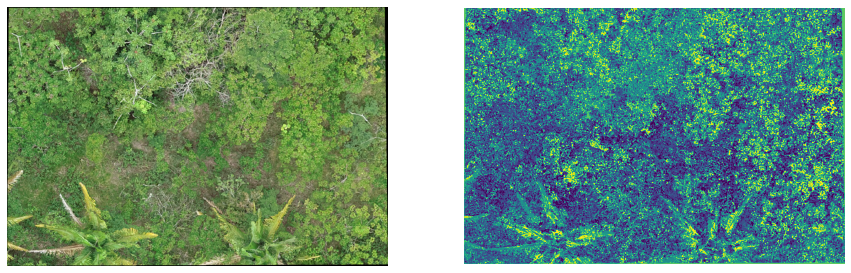

In [18]:
# The code below is to use the created kmeans algorithm to preview classes in other images without training

# open the raster image
prev_image = rio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/RGB_Teste_Kmeans.tif')
# create an empty array with same dimensions and data type 
prev_image_xyb = np.empty((prev_image.height, prev_image.width,prev_image.count), prev_image.meta['dtype'])
# loop through the raster bands and fill the empty array in x-y-bands order
for band in range(prev_image_xyb.shape[2]):
    prev_image_xyb[:,:,band] = prev_image.read(band+1)
# convert to 1d array
prev_image_1d = prev_image_xyb[:,:,:3].reshape(prev_image_xyb.shape[0]*prev_image_xyb.shape[1], prev_image_xyb.shape[2])
# predict the clusters in the image 
pred = cl.predict(prev_image_1d)
# reshape the 1d array predictions to x-y-bands shape order (only one band)
prev_image_cul = pred
prev_image_cul = prev_image_cul.reshape(prev_image_xyb[:,:,0].shape)

#Plot kmeans preview result (without trining) results

prev_image_arr = prev_image.read() # Read the image
vmin, vmax = np.nanpercentile(prev_image_arr, (5,95)) # 5–95% contrast stretch
# show the original and predicted image
fig, (ax1,ax2) = plt.subplots(figsize=[15,15], nrows=1,ncols=2, sharey=False,)
show(prev_image, cmap='gray', vmin=vmin, vmax=vmax, ax=ax1)
show(prev_image_cul, ax=ax2)#cmap=cmap, ax=ax2)
ax1.set_axis_off()
ax2.set_axis_off()
#fig.savefig("/path_to/pred.png", bbox_inches='tight')
plt.show()

In [68]:
# Applying Kmeans in RGB and CHM stacked data

# Stack chm and rgb arrays to apply Kmeans in the 4 layers

# For CHM database, which is converted to same RBG spatial resolution by QGis raster calculator, where one of
# the RGB bands is divided by itself to get a raster with 1 values only and then multiply it by CHM
dataset1 = rio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/CHM_sameRGBresolution.tif')
# Read as array
chm = dataset1.read(1).astype(int)*100
# Use mask to disconsider nodata or infinity values values
chm_mask = np.ma.masked_array(chm, mask=(chm == chm.min()))#dataset.nodata))# works for tiff statistics, but not for classification algorithms
print(chm_mask.shape)

# For RGB database
dataset2 = rio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/RGB_Teste_Kmeans.tif')
#rgb = dataset2.read()
r = dataset2.read(1)
g = dataset2.read(2)
b = dataset2.read(3)
print(r.shape)

all_lyrs = np.stack((chm_mask, r, g, b), axis=2)
print(all_lyrs.shape)

(995, 1478)
(995, 1478)
(995, 1478, 4)


In [69]:
# convert to 1d array
all_lyrs1d=all_lyrs[:,:,:4].reshape((all_lyrs.shape[0]*all_lyrs.shape[1],all_lyrs.shape[2]))
print(img1d.shape)

(1470610, 4)


In [70]:
cl = cluster.KMeans(n_clusters=5) # create an object of the classifier
param = cl.fit(all_lyrs1d) # train it
all_lyrs_cl = cl.labels_ # get the labels of the classes
all_lyrs_cl = all_lyrs_cl.reshape(all_lyrs[:,:,0].shape) # reshape labels to a 3d array (one band only)

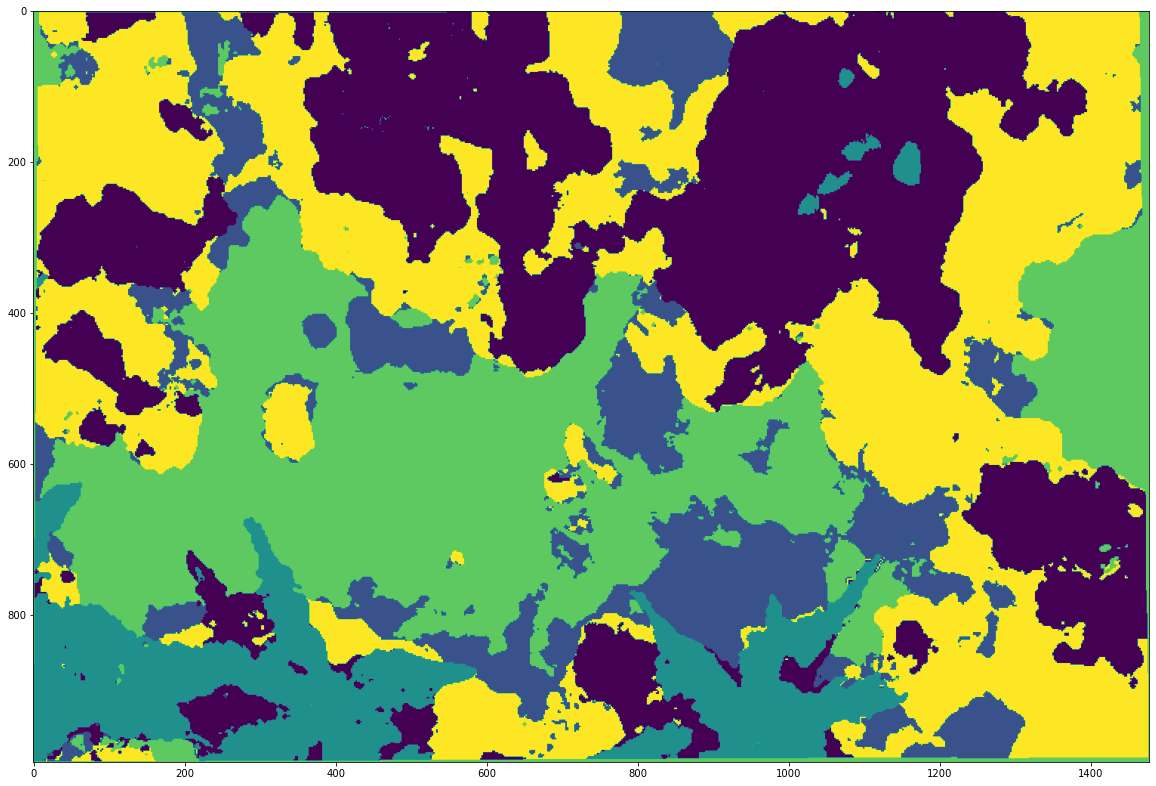

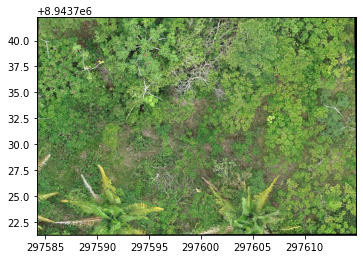

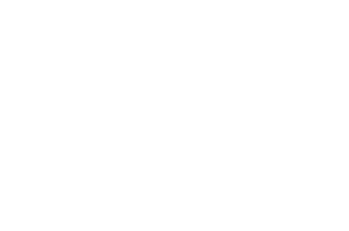

In [71]:
# Create a custom color map to represent our different 4 classes
#cmap = mc.LinearSegmentedColormap.from_list("", ["black","red","green","yellow"])
# Show the resulting array and save it as jpg image
plt.figure(figsize=[20,20])
#plt.imshow(img_cl)#, cmap=cmap)
show(all_lyrs_cl)
show(dataset2)
plt.axis('off')
#plt.savefig("/path_to/name_image.jpg", bbox_inches='tight')
plt.show()

In [60]:
# Export kmeans results as tiff file

with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = dataset2.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw')

    with rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/Kmeans_10classes.tif', 'w', **profile) as dst:
        dst.write(all_lyrs_cl.astype(rasterio.uint8), 1)


In [78]:
#Preview the obtainned kmeans classifier in another image with 4 stacked layers

# Stack chm and rgb arrays to apply Kmeans in the 4 layers

# For CHM database
prev_dataset1 = rio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/CHM_Kmeans_RGBresolution.tif')
# Read as array
chm = dataset1.read(1).astype(int)*100
# Use mask to disconsider nodata or infinity values values
chm_mask = np.ma.masked_array(chm, mask=(chm == chm.min()))#dataset.nodata))# works for tiff statistics, but not for classification algorithms
print(chm_mask.shape)

# For RGB database
prev_dataset2 = rio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/RGB_Kmeans.tif')
#rgb = dataset2.read()
r = dataset2.read(1)
g = dataset2.read(2)
b = dataset2.read(3)
print(r.shape)

prev_all_lyrs = np.stack((chm_mask, r, g, b), axis=2)
print(all_lyrs.shape)

(913, 1342)
(913, 1342)
(913, 1342, 4)


In [79]:
# convert to 1d array
prev_all_lyrs1d=prev_all_lyrs[:,:,:4].reshape((prev_all_lyrs.shape[0]*prev_all_lyrs.shape[1],prev_all_lyrs.shape[2]))
print(img1d.shape)

(1470610, 4)


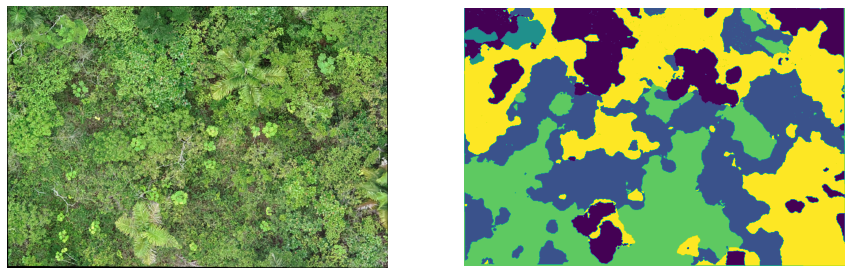

In [82]:
# predict the clusters in the image 
pred = cl.predict(prev_all_lyrs1d)
# reshape the 1d array predictions to x-y-bands shape order (only one band)
prev_image_cul = pred
prev_image_cul = prev_image_cul.reshape(prev_all_lyrs[:,:,0].shape)

#Plot kmeans preview result (without trining) results

prev_image_arr = prev_dataset2.read() # Read the image
vmin, vmax = np.nanpercentile(prev_image_arr, (5,95)) # 5–95% contrast stretch
# show the original and predicted image
fig, (ax1,ax2) = plt.subplots(figsize=[15,15], nrows=1,ncols=2, sharey=False,)
show(prev_dataset2, cmap='gray', vmin=vmin, vmax=vmax, ax=ax1)
show(prev_image_cul, ax=ax2)#cmap=cmap, ax=ax2)
ax1.set_axis_off()
ax2.set_axis_off()
#fig.savefig("/path_to/pred.png", bbox_inches='tight')
plt.show()